In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from astral import LocationInfo
from astral.sun import sun

blue = pd.read_csv("zurich_meteoblue_raw.csv",
                   parse_dates = ['time'], 
                   index_col = ['time'])

blue.rename(columns={"rel_humidity": "hum"}, inplace = True)

pi_data = pd.read_csv("airdata_raw.csv",
                 parse_dates = ['time'],
                 index_col = ['time'])

pi_data.rename(columns={"PM1": "PM1_pi", "PM2.5": "PM2.5_pi", "PM10": "PM10_pi"}, inplace = True)

In [15]:
#import scraped data (SBS = Stampfenbackstrasse)
col_names = ['location',
             'date',
             'hour',
             'weather',
             'temp_sbs',
             'hum_sbs',
             'wind',
             'pressure',
             'PM2.5',
             'PM10',
             'AQI']

sbs_data = pd.read_csv("WeatherData.csv", names=col_names, skiprows=[0], index_col = False, parse_dates=[['date', 'hour']],
                      dayfirst = True)
sbs_data.rename(columns={'date_hour':'time'}, inplace = True)

#get index column set to correct format / timezones
pd.to_datetime(sbs_data['time'])
sbs_data.set_index('time', inplace = True)
sbs_data.index = sbs_data.index.tz_localize("Europe/Zurich")

sbs_data = sbs_data.resample('h').mean() #resampling data frame for each hour to align for merge

In [16]:
#remove NaN and extreme negative outlier for sensor temperature data
pi_data.loc[pi_data['temp'] < -10] = np.nan
pi_data = pi_data.dropna() 

print(pi_data.isna().sum())
pi_data.describe()

id          0
temp        0
hum         0
PM1_pi      0
PM2.5_pi    0
PM10_pi     0
dtype: int64


,id,temp,hum,PM1_pi,PM2.5_pi,PM10_pi
count,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000,6179.000000
mean,3092.856935,10.646334,51.192911,4.694952,9.128555,13.678555
std,1784.098840,6.961464,14.925519,4.163538,7.024335,10.919859
min,1.000000,0.000000,17.300000,0.670000,0.740000,0.740000
25%,1548.500000,4.900000,39.700000,2.380000,4.430000,6.220000
50%,3093.000000,9.300000,51.700000,4.040000,7.740000,11.300000
75%,4637.500000,15.000000,62.550000,6.060000,12.190000,18.810000
max,6182.000000,32.400000,83.200000,190.930000,232.390000,257.730000


In [17]:
city = LocationInfo("Zurich", "Switzerland", "Europe/Zurich", 47.377, 8.542)

sunrise = []
noon = []
sunset = []

# setting range for months of march, april
for i in range(3,5):
    if i == 3:
        for j in range(1,32): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"])
            noon.append(s["noon"])
            sunset.append(s["sunset"])
    else:
        for j in range(1,31): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"])
            noon.append(s["noon"])
            sunset.append(s["sunset"])        
    
sunrise = pd.to_datetime(sunrise)
sunset = pd.to_datetime(sunset)
noon = pd.to_datetime(noon)

sun_data = pd.DataFrame({'sunrise':sunrise, 'noon':noon,'sunset':sunset}) 
sun_data['daylight'] = sun_data['sunset'] - sun_data['sunrise']
sun_data['date'] = sun_data['sunrise'].dt.date

In [18]:
rng = pd.date_range("2021-03-18", "2021-04-12", freq="h")

In [19]:
#resampling data frame for each hour
sensor_sampled = pi_data.resample('h').mean() 

#update indexes to same timezone
sensor_sampled.index = sensor_sampled.index.tz_convert("Europe/Zurich")
blue.index = blue.index.tz_localize("Europe/Zurich", nonexistent = 'shift_forward')

In [20]:
#merge sensor and meteoblue data
sensor_blue = pd.merge_ordered(sensor_sampled, blue, on = 'time', suffixes=('_pi', '_blue'), how='inner')
sensor_blue['date'] = sensor_blue['time'].dt.date

sensor_blue.set_index('time', inplace = True)
sensor_blue.index


DatetimeIndex(['2021-03-18 17:00:00+01:00', '2021-03-18 18:00:00+01:00',
               '2021-03-18 19:00:00+01:00', '2021-03-18 20:00:00+01:00',
               '2021-03-18 21:00:00+01:00', '2021-03-18 22:00:00+01:00',
               '2021-03-18 23:00:00+01:00', '2021-03-19 00:00:00+01:00',
               '2021-03-19 01:00:00+01:00', '2021-03-19 02:00:00+01:00',
               ...
               '2021-04-12 05:00:00+02:00', '2021-04-12 06:00:00+02:00',
               '2021-04-12 07:00:00+02:00', '2021-04-12 08:00:00+02:00',
               '2021-04-12 09:00:00+02:00', '2021-04-12 10:00:00+02:00',
               '2021-04-12 11:00:00+02:00', '2021-04-12 12:00:00+02:00',
               '2021-04-12 13:00:00+02:00', '2021-04-12 14:00:00+02:00'],
              dtype='datetime64[ns, Europe/Zurich]', name='time', length=598, freq=None)

In [21]:
#merge sensor+meteoblue with scraped data
sensor_blue_sbs = pd.merge_ordered(sensor_blue, sbs_data, on = 'time', suffixes = ('','_sbs'), how='inner')
sensor_blue_sbs.drop('id', axis = 'columns', inplace = True)
sensor_blue_sbs['date'] = sensor_blue_sbs['time'].dt.date

sensor_blue_sbs.head()

,time,temp_pi,hum_pi,PM1_pi,PM2.5_pi,PM10_pi,temp_blue,precip,hum_blue,wind_speed,wind_direction,cloud_cover,date,temp_sbs,hum_sbs,wind,pressure,PM2.5,PM10,AQI
0,2021-03-23 10:00:00+01:00,8.316667,53.283333,6.042500,11.798333,17.710000,3.106313,0.0,76.0,5.116561,50.710600,6.6,2021-03-23,3.0,65.0,3.7,1025.0,16.0,24.3,59.0
1,2021-03-23 11:00:00+01:00,13.408333,38.358333,4.840833,10.010000,15.388333,5.416314,0.0,67.0,6.924738,62.102737,18.0,2021-03-23,3.0,65.0,3.7,1025.0,14.0,20.9,55.0
2,2021-03-23 12:00:00+01:00,17.391667,32.191667,5.140833,7.510833,9.632500,7.216313,0.0,55.0,7.421590,67.166336,62.0,2021-03-23,7.0,57.0,14.8,1025.0,12.0,17.3,50.0
3,2021-03-23 13:00:00+01:00,18.650000,30.083333,3.752500,6.064167,8.284167,8.656314,0.0,48.0,6.952755,68.749500,70.0,2021-03-23,7.0,57.0,14.8,1025.0,NaN,NaN,27.0
4,2021-03-23 14:00:00+01:00,19.983333,28.125000,4.610000,10.042500,15.750000,9.586313,0.0,39.0,11.269782,63.434950,0.0,2021-03-23,9.0,40.0,11.1,1025.0,11.0,16.2,45.0


In [22]:
#add sunrise/sunset times
df_all = pd.merge_ordered(sensor_blue_sbs, sun_data, on = 'date', how ='inner', fill_method = 'ffill')
df_all.set_index('time', inplace = True)

df_all

,temp_pi,hum_pi,PM1_pi,PM2.5_pi,PM10_pi,temp_blue,precip,hum_blue,wind_speed,wind_direction,...,hum_sbs,wind,pressure,PM2.5,PM10,AQI,sunrise,noon,sunset,daylight
time,,,,,,,,,,,,,,,,,,,,,
2021-03-23 10:00:00+01:00,8.316667,53.283333,6.042500,11.798333,17.710000,3.106313,0.0,76.0,5.116561,50.710600,...,65.0,3.7,1025.0,16.0,24.3,59.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 11:00:00+01:00,13.408333,38.358333,4.840833,10.010000,15.388333,5.416314,0.0,67.0,6.924738,62.102737,...,65.0,3.7,1025.0,14.0,20.9,55.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 12:00:00+01:00,17.391667,32.191667,5.140833,7.510833,9.632500,7.216313,0.0,55.0,7.421590,67.166336,...,57.0,14.8,1025.0,12.0,17.3,50.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 13:00:00+01:00,18.650000,30.083333,3.752500,6.064167,8.284167,8.656314,0.0,48.0,6.952755,68.749500,...,57.0,14.8,1025.0,NaN,NaN,27.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 14:00:00+01:00,19.983333,28.125000,4.610000,10.042500,15.750000,9.586313,0.0,39.0,11.269782,63.434950,...,40.0,11.1,1025.0,11.0,16.2,45.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 10:00:00+02:00,5.350000,77.241667,3.190000,6.740000,10.450833,1.286314,1.2,93.0,16.935310,2.436646,...,93.0,5.5,1023.0,3.0,5.6,12.0,2021-04-12 06:43:17.148768+02:00,2021-04-12 13:26:40+02:00,2021-04-12 20:10:43.726239+02:00,0 days 13:27:26.577471
2021-04-12 11:00:00+02:00,5.975000,75.625000,1.982500,3.617500,5.262500,1.306314,0.9,92.0,17.917007,22.442749,...,93.0,9.3,1024.0,NaN,5.8,10.0,2021-04-12 06:43:17.148768+02:00,2021-04-12 13:26:40+02:00,2021-04-12 20:10:43.726239+02:00,0 days 13:27:26.577471
2021-04-12 12:00:00+02:00,6.372727,72.300000,3.828182,8.692727,13.842727,1.426314,0.8,92.0,13.684735,35.362457,...,93.0,9.3,1024.0,NaN,6.0,11.0,2021-04-12 06:43:17.148768+02:00,2021-04-12 13:26:40+02:00,2021-04-12 20:10:43.726239+02:00,0 days 13:27:26.577471


In [23]:
#export sampled file to CSV9
df_all.to_csv('1h_sampled_data.csv', index=True)
df_all.head()

,temp_pi,hum_pi,PM1_pi,PM2.5_pi,PM10_pi,temp_blue,precip,hum_blue,wind_speed,wind_direction,...,hum_sbs,wind,pressure,PM2.5,PM10,AQI,sunrise,noon,sunset,daylight
time,,,,,,,,,,,,,,,,,,,,,
2021-03-23 10:00:00+01:00,8.316667,53.283333,6.042500,11.798333,17.710000,3.106313,0.0,76.0,5.116561,50.710600,...,65.0,3.7,1025.0,16.0,24.3,59.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 11:00:00+01:00,13.408333,38.358333,4.840833,10.010000,15.388333,5.416314,0.0,67.0,6.924738,62.102737,...,65.0,3.7,1025.0,14.0,20.9,55.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 12:00:00+01:00,17.391667,32.191667,5.140833,7.510833,9.632500,7.216313,0.0,55.0,7.421590,67.166336,...,57.0,14.8,1025.0,12.0,17.3,50.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 13:00:00+01:00,18.650000,30.083333,3.752500,6.064167,8.284167,8.656314,0.0,48.0,6.952755,68.749500,...,57.0,14.8,1025.0,NaN,NaN,27.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414
2021-03-23 14:00:00+01:00,19.983333,28.125000,4.610000,10.042500,15.750000,9.586313,0.0,39.0,11.269782,63.434950,...,40.0,11.1,1025.0,11.0,16.2,45.0,2021-03-23 06:22:52.709917+01:00,2021-03-23 12:32:27+01:00,2021-03-23 18:42:36.960331+01:00,0 days 12:19:44.250414


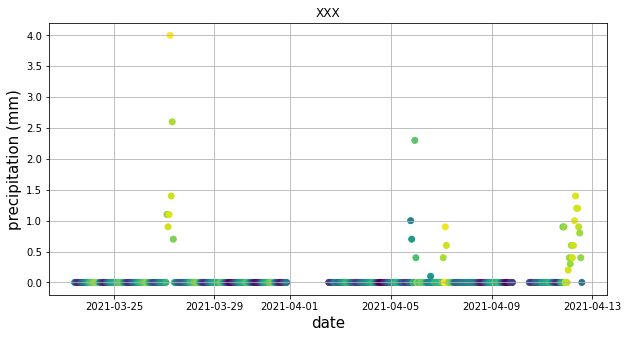

In [24]:
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(df_all.index,df_all["precip"],c = df_all["hum_pi"])

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('precipitation (mm)', fontsize=15)
ax.set_title('XXX')

ax.grid(True)

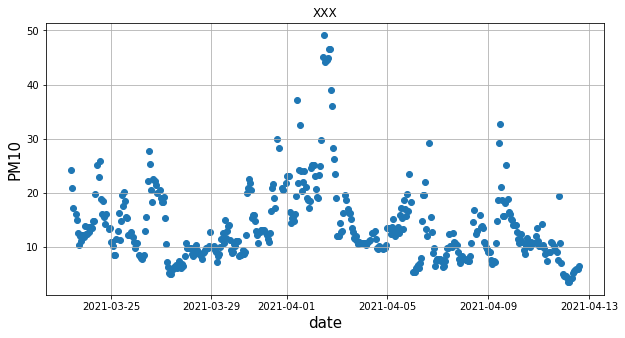

In [25]:
fig, ax = plt.subplots(figsize = (10,5))
plt.scatter(df_all.index,df_all["PM10"])

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('PM10', fontsize=15)
ax.set_title('XXX')

ax.grid(True)